In [2]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxa

from rasterio.enums import Resampling

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

image_fps = [f for f in image_fps if f['fp'].endswith('.unw.grd.tiff')]

In [3]:
from math import cos, sin, asin, sqrt, radians
def calc_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

In [4]:
l_fps = []
for fps in image_fps:
    if fps['location'] == 'Lowman, CO':
        if fps['pol'] == 'VV':
            l_fps.append(fps)

In [5]:
bands = []
for i, fps in enumerate(l_fps):
    print(i, end = '.')
    name = basename(fps['fp'])
    name = '_'.join(name.split('.')[0].split('_')[:5])
    bands.append(name)
    cor = rxa.open_rasterio(fps['cor'])
    desc = pd.read_csv(fps['ann'])
    if i == 0:
        # calculate how to get to 30 metere resolution from 0.0005 degrees
        new_res_m = 30
        y1 = float(desc['grd.row_addr'][0])
        dy = float(desc['grd.row_mult'][0])
        x1 = float(desc['grd.col_addr'][0])
        dx = float(desc['grd.col_mult'][0])
        conversion = (new_res_m/1000) / calc_distance(y1, x1, y1+dy, x1 + dx)
        cor_coarse = cor.rio.reproject(cor.rio.crs, \
                                        shape = (int(cor.rio.height/conversion), int(cor.rio.width/conversion)),
                                        resampling = Resampling.average)
        cor_base = cor_coarse.copy()
        cor_coarse.values[0]
        cor_vv = np.zeros((len(l_fps), *cor_coarse.values[0].shape))
    else:
        cor_coarse = cor.rio.reproject_match(cor_base)
    cor_vv[i] = cor_coarse.values[0]

cor_vv = xr.Dataset(
    data_vars = dict(
        cor_vv = (["band", "y", "x"], cor_vv)
    ),
    coords = dict(
        lon = (["x"], cor_coarse.x.data),
        lat = (["y"], cor_coarse.y.data),
        band = bands
    ),
    attrs = dict(description = "Coherence for VV over lowman")
)

#cor_vv.sel({'band' : bands[1]})['cor_vv']

0.1.2.3.4.5.6.7.8.9.10.11.12.13.

In [7]:
cor_coarse.data[0] = cor_vv.reduce(dim = "band", func = np.mean)['cor_vv'].data

(44.1, 44.4)

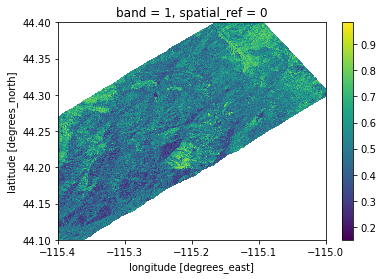

In [8]:
cor_coarse.plot()
plt.xlim(-115.4, -115)
plt.ylim(44.1, 44.4)

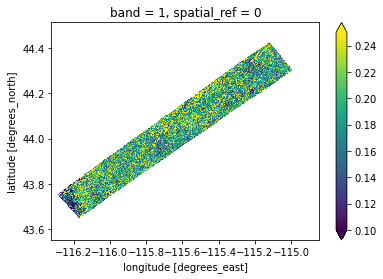

In [194]:
cor_coarse.plot(vmin = 0.1, vmax = 0.25)